In [ ]:
!pip install pyomo

In [85]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Products
products = {
    'P1' : {'ACR' : 40, 'labor': 2,   'demand': 400},
    'P2' : {'ACR' : 30, 'labor': 1,   'demand': 400},
    'P3' : {'ACR' : 20, 'labor': 0.5, 'demand': 800},
    'P4' : {'ACR' : 25, 'labor': 0.5, 'demand': 400},
    'P5' : {'ACR' : 45, 'labor': 2,   'demand': 400}
}

factory = {'F1' : {'production' : 1000, 'hours': 730, 'Max_capacity_%':1.},
           'F2' : {'production' : 500 , 'hours': 730, 'Max_capacity_%':1.},
           'F3' : {'production' : 800,  'hours': 730, 'Max_capacity_%':1.00},
           'F4' : {'production' : 1500, 'hours': 730, 'Max_capacity_%':1.00},
           'F5' : {'production' : 300 , 'hours': 730, 'Max_capacity_%':1.00}
           }

In [2]:
y = {'F1': {'P1','P2','P5'},
     'F2': {'P3', 'P4'},
     'F3': {'P1','P4','P5'},
     'F4': {'P1','P2','P3','P5'},
     'F5': {'P3'}}

In [3]:
dict(y)

{'F1': {'P1', 'P2', 'P5'},
 'F2': {'P3', 'P4'},
 'F3': {'P1', 'P4', 'P5'},
 'F4': {'P1', 'P2', 'P3', 'P5'},
 'F5': {'P3'}}

In [4]:
P = products.keys()
F = factory.keys()

In [5]:
df = pd.Series({(f,p): 1 for f in F for p in y[f]}).to_frame().reset_index()
df.columns = ['f','p','adjancecy']
pd.crosstab(df['f'],df['p'])

p,P1,P2,P3,P4,P5
f,,,,,
F1,1,1,0,0,1
F2,0,0,1,1,0
F3,1,0,0,1,1
F4,1,1,1,0,1
F5,0,0,1,0,0


In [6]:

# create model
model = ConcreteModel()

In [7]:
model.F = Set(initialize = F)
model.P = Set(initialize = P)
model.FxP = Set(within = model.F*model.P, initialize={(f,p) for f in model.F for p in y[f]})
model.y = Param(model.F, within = Any, default = (), initialize = y)

In [8]:
model.x = Var(model.FxP, domain = NonNegativeReals)

In [9]:
# Variables

# Objective
model.profit = Objective(expr = sum(model.x[f,p]*products[p]['ACR'] for f in model.F for p in model.y[f]) ,sense = maximize)

model.cons = ConstraintList()
# Produciton constraint
def demand_constraint(model,i):
    return sum(model.x[f,p] for (f,p) in model.FxP if p == i) <= products[i]['demand']
model.demand = Constraint(model.P, rule = demand_constraint)
def capacity_constraint(model,f):
    return sum(model.x[f,p] for p in model.y[f]) <= factory[f]['Max_capacity_%']*factory[f]['production']
model.capacity = Constraint(model.F, rule = capacity_constraint)
def time_constraint(model,f):
    return sum(model.x[f,p]*products[p]['labor'] for p in model.y[f]) <= factory[f]['hours']
model.time = Constraint(model.F, rule = time_constraint)



# solve
results = SolverFactory('glpk').solve(model)
results.write()
if results.solver.status:
    model.pprint()



# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 71800.0
  Upper bound: 71800.0
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 14
  Number of nonzeros: 40
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.22324633598327637
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

In [10]:
# display solution

print(f'\nProfit = ${model.profit()}')

print('\nDecision Variables')

hours_working = dict()
capacity = dict()
for f in F:
    capacity[f] = 100*sum(model.x[f,p]() for p in model.y[f])/factory[f]['production']
    hours_working[f] = 100*sum(model.x[f,p]()*products[p]['labor'] for p in model.y[f])/factory[f]['hours']

df_factory = pd.DataFrame()
for f in F:
    df_factory.loc[f,'Production'] = sum(model.x[f,p]() for p in model.y[f])
    df_factory.loc[f,'% Capacity'] = capacity[f]
    df_factory.loc[f,'Working hours'] = sum(model.x[f,p]()*products[p]['labor'] for p in model.y[f])
    df_factory.loc[f,'% Hours'] = hours_working[f]

df_factory.loc['Mean'] = df_factory.mean()
print(df_factory)


Profit = $71800.0

Decision Variables
      Production  % Capacity  Working hours     % Hours
F1         565.0   56.500000          730.0  100.000000
F2         500.0  100.000000          250.0   34.246575
F3         365.0   45.625000          730.0  100.000000
F4         665.0   44.333333          730.0  100.000000
F5         300.0  100.000000          150.0   20.547945
Mean       479.0   69.291667          518.0   70.958904


In [49]:
df_factory.iloc[0:5].index.tolist()

['F1', 'F2', 'F3', 'F4', 'F5']

<Figure size 576x360 with 0 Axes>

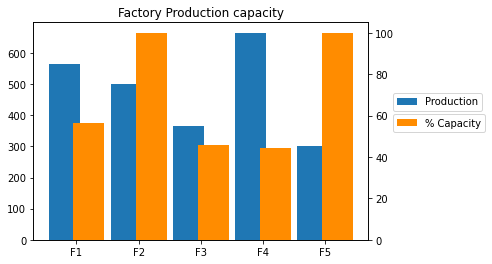

In [113]:
plt.figure(figsize=(8,5))
x = np.arange(len(df_factory.iloc[0:5].index))
fig, ax = plt.subplots()
ax2 = ax.twinx()
re1 = ax.bar( x- 0.2, df_factory.iloc[0:5]['Production'],width=0.5,label='Production')
re2 = ax2.bar(x + 0.2, df_factory.iloc[0:5]['% Capacity'],width=0.5,label='% Capacity', color = 'darkorange')
plt.xticks(ticks =x,labels= df_factory.iloc[0:5].index.tolist())
plt.title('Factory Production capacity')
ax.legend(bbox_to_anchor = (1.355,0.7))
ax2.legend(bbox_to_anchor = (1.06,0.6))
plt.show()

In [89]:


df_product = pd.DataFrame()
for f in F:
    for p in model.y[f]:
        df_product.loc[p,f] = model.x[f,p]()
df_product=df_product.fillna(0)
df_product['Total Produced'] = df_product.sum(axis=1)
df_product.loc['Total Produced'] = df_product.sum()
df_product.sort_index(inplace=True)

print(df_product)

                   F1     F2     F3     F4     F5  Total Produced
P1               30.0    0.0  365.0    0.0    0.0           395.0
P2              400.0    0.0    0.0    0.0    0.0           400.0
P3                0.0  100.0    0.0  400.0  300.0           800.0
P4                0.0  400.0    0.0    0.0    0.0           400.0
P5              135.0    0.0    0.0  265.0    0.0           400.0
Total Produced  565.0  500.0  365.0  665.0  300.0          2395.0


In [90]:
df_demand = pd.DataFrame()
for f in F:
    for p in model.y[f]:
        df_demand.loc[p,f] = 100*model.x[f,p]()/products[p]['demand']
df_demand = df_demand.fillna(0)
df_demand['% Demand Fulfilled'] = df_demand.sum(axis=1)
df_demand.sort_index(inplace=True)

print(df_demand)

        F1     F2     F3     F4    F5  % Demand Fulfilled
P1    7.50    0.0  91.25   0.00   0.0               98.75
P2  100.00    0.0   0.00   0.00   0.0              100.00
P3    0.00   12.5   0.00  50.00  37.5              100.00
P4    0.00  100.0   0.00   0.00   0.0              100.00
P5   33.75    0.0   0.00  66.25   0.0              100.00


<Figure size 576x360 with 0 Axes>

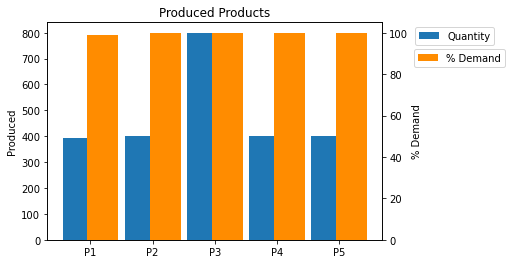

In [123]:
df_pr = pd.DataFrame()
df_pr = pd.concat([df_product.iloc[0:5]['Total Produced'],df_demand['% Demand Fulfilled']],axis=1)


plt.figure(figsize=(8,5))
x = np.arange(len(df_pr.index))
fig, ax = plt.subplots()
ax2 = ax.twinx()
re1 = ax.bar( x- 0.2, df_pr['Total Produced'],width=0.5,label='Quantity')
re2 = ax2.bar(x + 0.2, df_pr['% Demand Fulfilled'],width=0.5,label='% Demand', color = 'darkorange')
plt.xticks(ticks =x,labels= df_pr.index.tolist())
plt.title('Produced Products')
ax.legend(bbox_to_anchor = (1.35,1))
ax2.legend(bbox_to_anchor = (1.08,0.9))
ax2.set_ylabel('% Demand')
ax.set_ylabel('Produced')
plt.show()


,F1,F2,F3,F4,F5
P1,0.053097,0.0,1.0,0.000000,0.0
P2,0.707965,0.0,0.0,0.000000,0.0
P3,0.000000,0.2,0.0,0.601504,1.0
P4,0.000000,0.8,0.0,0.000000,0.0
P5,0.238938,0.0,0.0,0.398496,0.0


<Figure size 576x360 with 0 Axes>

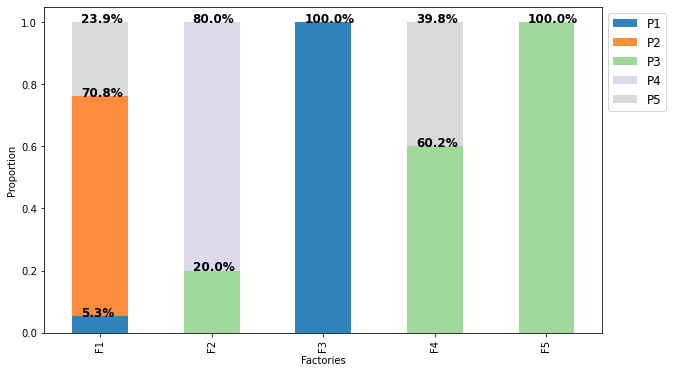

In [174]:
df_pr2 = df_product.iloc[0:5,0:5]
df_pr2 = df_pr2/df_pr2.sum()

plt.figure(figsize=(8,5))
df_pr2.T.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20c', 
                    figsize=(10, 6))

plt.legend(bbox_to_anchor = (1.,1), ncol=1, fontsize = 12)
plt.xlabel("Factories")
plt.ylabel("Proportion")

for n, x in enumerate([*df_pr2.T.index.values]):
    for (proportion, y_loc) in zip(df_pr2.T.loc[x],
                                   df_pr2.T.loc[x].cumsum()):
        if np.round(proportion * 100, 1) != 0:
            plt.text(x=n - 0.17,
                     y=y_loc,
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="black",
                     fontsize=12,
                     fontweight="bold")
         

plt.show()